# Thư viện cần dùng

In [65]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Đọc và chia dữ liệu

In [39]:
train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values = pd.read_csv("test_values.csv")
submission_format = pd.read_csv("submission_format.csv")

Kết hợp train values và labels thành train data bằng cách inner join với trường "building_id"

In [40]:
nepal_data = train_values.merge(train_labels, how='inner', on='building_id')
len(nepal_data)

260601

Các trường của bộ dữ liệu

In [41]:
int_data=['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq','age', 'area_percentage', 'height_percentage', 'count_families', 'damage_grade']

# categorical_data=['land_surface_condition', 'foundation_type', 'roof_type',
#        'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 
#        'legal_ownership_status']

# binary_data=['has_superstructure_adobe_mud',
#        'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
#        'has_superstructure_cement_mortar_stone',
#        'has_superstructure_mud_mortar_brick',
#        'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
#        'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
#        'has_superstructure_rc_engineered', 'has_superstructure_other',
#        'has_secondary_use', 'has_secondary_use_agriculture',
#        'has_secondary_use_hotel',
#        'has_secondary_use_rental', 'has_secondary_use_institution',
#        'has_secondary_use_school', 'has_secondary_use_industry',
#        'has_secondary_use_health_post', 'has_secondary_use_gov_office',
#        'has_secondary_use_use_police', 'has_secondary_use_other']

Chỉ lấy ra các trường có kiểu dữ liệu là int, bỏ qua loại categorical và binary vì không dùng cho hồi quy tuyến tính

In [42]:
int_nepal_data = nepal_data[int_data]

print(len(int_nepal_data))
print(int_nepal_data.columns.tolist())
print(int_nepal_data.head())

260601
['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families', 'damage_grade']
   building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6             487           12198   
1        28830               8             900            2812   
2        94947              21             363            8973   
3       590882              22             418           10694   
4       201944              11             131            1488   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

   count_families  

Chia dữ liệu thành tập train và tập validation

In [43]:
x = int_nepal_data[['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 
                    'age', 'area_percentage', 'height_percentage', 'count_families']]
y = int_nepal_data['damage_grade']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [44]:
len(x_train)

208480

In [45]:
len(x_val)

52121

# Xây dựng phương trình hồi quy tuyến tính bằng thư viện 

In [46]:
regr = LinearRegression(fit_intercept=True)

regr.fit(x_train, y_train)

print("Coefs: ", regr.coef_)
print("Intercept: ", regr.intercept_)

Coefs:  [-3.90894484e-03  4.23804890e-05  1.69907383e-06  1.51336453e-01
  1.17275867e-04 -1.77852547e-02 -2.35407162e-02  8.69045932e-02]
Intercept:  2.112341293940858


* Vậy phương trình hồi quy tuyến tính là:
* damage_grade = 2.112341293940858 
                + (-3.90894484e-03) * geo_level_1_id
                + 4.23804890e-05    * geo_level_2_id
                + 1.69907383e-06    * geo_level_3_id
                + 1.51336453e-01    * count_floors_pre_eq
                + 1.17275867e-04    * age
                + (-1.77852547e-02) * area_percentage
                + (-2.35407162e-02) * height_percentage 
                + 8.69045932e-02    * count_families*

Kiểm tra trên x_val và lấy ra accuracy, confusion matrix, precision, recall

In [47]:
# Dự đoán
y_pred = regr.predict(x_val)
y_pred

array([2.18950049, 2.22508793, 2.20282515, ..., 2.31521882, 2.26996249,
       2.26781807])

Do khi thay các giá trị trong x_val vào phương trình hồi quy tuyến tính, kết quả dự đoán của y_pred sẽ là các số thực, mà bài toán đang cần phân lớp nên ta làm tròn kết quả

In [48]:
y_pred = np.round(y_pred, 0).astype(int)
y_pred

array([2, 2, 2, ..., 2, 2, 2])

Kiểm tra xem giá trị của y_pred có bị làm tròn ra ngoài các lớp cần dự đoán

In [49]:
count = np.sum((y_pred < 1) | (y_pred > 3))
print("Số lượng giá trị nhỏ hơn 1 hoặc lớn hơn 3 trong y_pred:", count)

Số lượng giá trị nhỏ hơn 1 hoặc lớn hơn 3 trong y_pred: 0


In [66]:
mse = mean_squared_error(y_val, y_pred)
print("MSE: ", mse)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: ", accuracy)

precision = precision_score(y_val, y_pred, average="weighted")
print("Precision: ", precision)

recall = recall_score(y_val, y_pred, average="weighted")
print("Recall: ", recall)

f1 = f1_score(y_val, y_pred, average="weighted")
print("F1-score: ", f1)

cfs_matrix = confusion_matrix(y_val, y_pred)
print("Confusion matrix: ")
print(cfs_matrix)


MSE:  0.44149191304848334
Accuracy:  0.5604075132863913
Precision:  0.4674859305121396
Recall:  0.5604075132863913
F1-score:  0.4156335531639682
Confusion matrix: 
[[   14  5129    27]
 [   13 28931   543]
 [    6 17194   264]]


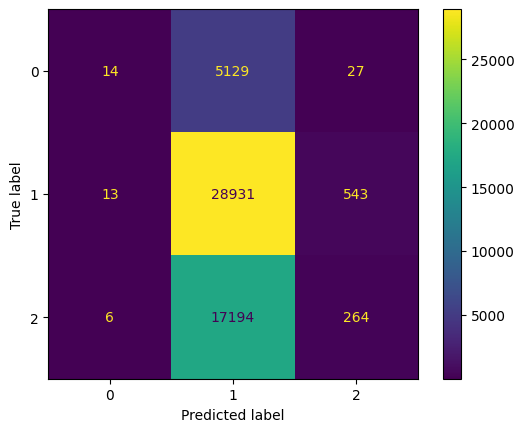

In [51]:
ConfusionMatrixDisplay(cfs_matrix).plot()

In [52]:
from sklearn.metrics import classification_report

report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.42      0.00      0.01      5170
           2       0.56      0.98      0.72     29487
           3       0.32      0.02      0.03     17464

    accuracy                           0.56     52121
   macro avg       0.44      0.33      0.25     52121
weighted avg       0.47      0.56      0.42     52121



Dự đoán cho file test

In [53]:
x_test = test_values[['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 
                    'age', 'area_percentage', 'height_percentage', 'count_families']]

x_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
0,17,596,11307,3,20,7,6,1
1,6,141,11987,2,25,13,5,1
2,22,19,10044,2,5,4,5,1
3,26,39,633,1,0,19,3,2
4,17,289,7970,3,15,8,7,1
...,...,...,...,...,...,...,...,...
86863,4,605,3623,3,70,20,6,1
86864,10,1407,11907,3,25,6,7,1
86865,22,1136,7712,1,50,3,3,1
86866,6,1041,912,2,5,9,5,1


In [54]:
y_test_pred = regr.predict(x_test)
y_test_pred = np.round(y_test_pred, 0).astype(int)
y_test_pred

array([2, 2, 2, ..., 2, 2, 2])

In [55]:
submission = {
    'building_id': test_values['building_id'],
    'damage_grade': y_test_pred
}
df = pd.DataFrame(submission)

df.to_csv('linear_submission.csv', index=False)

# Tự xây dựng code hồi quy tuyến tính

Tự xây dựng thuật toán Normal Equation

In [61]:
class LinearRegressionNE:
    def __init__(self):
        pass

    def preprocess(self, X):
        X = np.column_stack((np.ones(len(X)), X))
        return X

    def fit(self, X, y):
        X = self.preprocess(X)
        Xt = np.dot(X.T, X)
        Xt_invert= np.linalg.inv(Xt)
        Xy = np.dot(X.T, y)
        coefficients = np.dot(Xt_invert, Xy)
        return coefficients

    def predict(self, X_test, coefficients):
        X_test = self.preprocess(X_test)
        y_pred = np.dot(X_test, coefficients)
        return y_pred

In [62]:
lr = LinearRegressionNE()
coeffs = lr.fit(x_train, y_train)

y_pred_rounded = np.round(lr.predict(x_val, coeffs),0).astype(int)

accuracy = np.mean(y_pred_rounded == y_val)
# print("Accuracy:", accuracy)
print("Coefficients:", coeffs)

Coefficients: [ 2.11234129e+00 -3.90894484e-03  4.23804890e-05  1.69907383e-06
  1.51336453e-01  1.17275867e-04 -1.77852547e-02 -2.35407162e-02
  8.69045932e-02]


In [63]:
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: ", accuracy)

precision = precision_score(y_val, y_pred, average="weighted")
print("Precision: ", precision)

recall = recall_score(y_val, y_pred, average="weighted")
print("Recall: ", recall)

cfs_matrix = confusion_matrix(y_val, y_pred)
print("Confusion matrix: ")
print(cfs_matrix)

Accuracy:  0.5604075132863913
Precision:  0.4674859305121396
Recall:  0.5604075132863913
Confusion matrix: 
[[   14  5129    27]
 [   13 28931   543]
 [    6 17194   264]]


Dùng thuật toán HoldHouse để khai triển QR

In [58]:
def qr_householder(A):
    #""" Compute QR decomposition of A using Householder reflection"""
    M = A.shape[0]
    N = A.shape[1]

    # set Q to the identity matrix
    # Tạo ma trận đơn vị có số hàng = số hàng của ma trận A
    Q = np.identity(M)

    # set R to zero matrix
    R = np.copy(A)

    for n in range(N):
        # vector to transform
        x = A[n:, n]
        k = x.shape[0]

        # compute ro=-sign(x0)||x||
        ro = -np.sign(x[0]) * np.linalg.norm(x)

        # compute the householder vector v
        e = np.zeros(k)
        e[0] = 1
        v = (1 / (x[0] - ro)) * (x - (ro * e))

        # apply v to each column of A to find R
        for i in range(N):
            R[n:, i] = R[n:, i] - (2 / (v@v)) * ((np.outer(v, v)) @ R[n:, i])

        # apply v to each column of Q
        for i in range(M):
            Q[n:, i] = Q[n:, i] - (2 / (v@v)) * ((np.outer(v, v)) @ Q[n:, i])

    return Q.transpose(), R

def linear_regression(x_data, y_data):
    # """

    # This function calculate linear regression base on x_data and y_data
    # :param x_data: vector
    # :param y_data: vector
    # :return: w (regression estimate)
    # """

    # add column 1
    x_bars = np.concatenate((np.ones((x_data.shape[0], 1)), x_data), axis=1)

    Q, R = qr_householder(x_bars) # QR decomposition
    R_pinv = np.linalg.pinv(R) # calculate inverse matrix of R
    A = np.dot(R_pinv, Q.T) # apply formula

    return np.dot(A, y_data)

w = linear_regression(x_train, y_train) # get result
w = w.T.tolist()
line = ['Intercept', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 
        'age', 'area_percentage', 'height_percentage', 'count_families']
res = list(zip(line, w[0]))

for o in res:
    print("{: >20}: {: >10}".format(*o))

MemoryError: Unable to allocate 324. GiB for an array with shape (208480, 208480) and data type float64

In [ ]:
import numpy as np
def gs(A):
    m = np.shape(A)[0]
    n = np.shape(A)[1]
    Q =  np.zeros((m, m))
    R =  np.zeros((n, n)) 
    for j in range(n):
        v = A[:,j]
        for i in range(j):
            R[i,j] =  np.dot(Q[:,i].T , A[:,j]) 
            v = v.squeeze() - (R[i,j] * Q[:,i])
        R[j,j] =  np.linalg.norm(v)
        Q[:,j] = (v / R[j,j]).squeeze()
    return Q, R

def linear_regression(x_data, y_data):
    # """

    # This function calculate linear regression base on x_data and y_data
    # :param x_data: vector
    # :param y_data: vector
    # :return: w (regression estimate)
    # """

    # add column 1
    x_bars = np.concatenate((np.ones((x_data.shape[0], 1)), x_data), axis=1)

    Q, R = gs(x_bars) # QR decomposition
    R_pinv = np.linalg.pinv(R) # calculate inverse matrix of R
    A = np.dot(R_pinv, Q.T) # apply formula

    return np.dot(A, y_data)

w = linear_regression(x_train, y_train) # get result
w = w.T.tolist()
line = ['Intercept', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 
        'age', 'area_percentage', 'height_percentage', 'count_families']
res = list(zip(line, w[0]))

for o in res:
    print("{: >20}: {: >10}".format(*o))

MemoryError: Unable to allocate 324. GiB for an array with shape (208480, 208480) and data type float64

Không đủ bộ nhớ để tạo một mảng NumPy có kích thước lớn như (208480, 208480) với kiểu dữ liệu float64